In [2]:
import os
from google.cloud.bigquery.client import Client

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:\\Users\\Francesco\\fiery-rarity-322109-6ba6fa8a811c.json' #service-account-file.json
bq_client = Client()

In [3]:
%load_ext google.cloud.bigquery

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# set seaborn plotting theme
sns.set_theme()

# set colour palette
pal = ['#00388F', '#FFB400', '#FF4B00', '#65B800', '#00B1EA']

In [5]:
# from google.cloud import bigquery

# client = bigquery.Client(project=project_id)

# sample_count = 2000
# row_count = client.query('''
#   SELECT 
#     COUNT(*) as total
#   FROM `bigquery-public-data.samples.gsod`''').to_dataframe().total[0]

# df = client.query('''
#   SELECT
#     *
#   FROM
#     `bigquery-public-data.samples.gsod`
#   WHERE RAND() < %d/%d
# ''' % (sample_count, row_count)).to_dataframe()

# EDA

## Nr of traces

In [6]:
%%bigquery traces_count --project fiery-rarity-322109

select TIMESTAMP_TRUNC(block_timestamp, MONTH) as date
, sum(case when trace_type = 'call' and to_contract_type is not null then 1 else 0 end) as call
, sum(case when trace_type = 'call' and to_contract_type is null then 1 else 0 end) as transfer
, sum(case when trace_type = 'reward' then 1 else 0 end) as reward
, sum(case when trace_type = 'create' then 1 else 0 end) as create_
, sum(case when trace_type = 'suicide' then 1 else 0 end) as suicide
, sum(case when trace_type = 'genesis' then 1 else 0 end) as genesis
, sum(case when trace_type = 'daofork' then 1 else 0 end) as daofork
FROM `fiery-rarity-322109.ethereum.traces_new`
group by date
order by date

Downloading: 100%|██████████| 73/73 [00:02<00:00, 26.39rows/s]


In [ ]:
fig, ax1 = plt.subplots(2, 1, figsize=(8, 6))

ax1[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1[0].stackplot(traces_count.date, traces_count.transfer, traces_count.call, labels = ['transfer', 'call'], colors = pal, linewidth = 0)
ax1[0].legend(loc = 'upper left', frameon = False)
ax1[0].set_ylabel('Number of records')

ax1[1].stackplot(traces_count.date, traces_count.reward, traces_count.create_, traces_count.suicide
                 , labels = ['reward', 'create', 'suicide'], colors = pal, linewidth = 0)
ax1[1].legend(loc = 'upper left', frameon = False)
ax1[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1[1].set_ylabel('Number of records')
# ax1[1].set_ylim(ymax = 1e3)
ax2 = ax1[1].twinx()
ax2.stackplot(traces_count.date, traces_count.genesis, traces_count.daofork
                 , labels = ['genesis', 'daofork'], colors = pal[3:], linewidth = 0)
ax2.legend(loc = 'upper right', frameon = False)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax2.set_ylabel('Number of records')
ax2.grid(False)
# ax2.set_ylim(ymax = 1e3)

# plt.tight_layout()
# plt.show()

plt.savefig('charts/number_transactions_monthly.pdf')

In [11]:
%%bigquery traces_value --project fiery-rarity-322109

select TIMESTAMP_TRUNC(block_timestamp, MONTH) as date
, sum(case when trace_type = 'call' and to_contract_type is not null then value else 0 end) / 1e18 as call
, sum(case when trace_type = 'call' and to_contract_type is null then value else 0 end) / 1e18 as transfer
, sum(case when trace_type = 'reward' then value else 0 end) / 1e18 as reward
, sum(case when trace_type = 'create' then value else 0 end) / 1e18 as create_
, sum(case when trace_type = 'suicide' then value else 0 end) / 1e18 as suicide
, sum(case when trace_type = 'genesis' then value else 0 end) / 1e18 as genesis
, sum(case when trace_type = 'daofork' then value else 0 end) / 1e18 as daofork
FROM `fiery-rarity-322109.ethereum.traces_new`
group by date
order by date

Downloading: 100%|██████████| 73/73 [00:02<00:00, 25.67rows/s]


In [ ]:
fig, ax1 = plt.subplots(2, 1, figsize=(8,6))

ax1[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1[0].stackplot(traces_value.date, traces_value.transfer, traces_value.call, labels = ['transfer', 'call'], colors = pal, linewidth = 0)
ax1[0].legend(loc = 'upper left', frameon = False)
ax1[0].set_ylabel('Value, ETH')

ax1[1].stackplot(traces_value.date, traces_value.reward, traces_value.create_, traces_value.suicide
                 , labels = ['reward', 'create', 'suicide'], colors = pal, linewidth = 0)
ax1[1].legend(loc = 'upper left', frameon = False)
ax1[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1[1].set_ylabel('Value, ETH')


ax2 = ax1[1].twinx()
ax2.stackplot(traces_value.date, traces_value.genesis, traces_value.daofork
                 , labels = ['genesis', 'daofork'], colors = pal[3:], linewidth = 0)
ax2.legend(loc = 'upper right', frameon = False)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax2.set_ylabel('Value, ETH')
ax2.grid(False)


# plt.tight_layout()
# plt.show()

plt.savefig('charts/value_transactions_monthly.pdf')

## Supply and market capitalization

In [15]:
%%bigquery market_data --project fiery-rarity-322109

SELECT  TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) as date, close, high, low, volumeto as volume
FROM `fiery-rarity-322109.ethereum.eth_usd_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) and DATE(TIMESTAMP_SECONDS(time)) <= '2021-07-30'
order by date

Downloading: 100%|██████████| 52425/52425 [00:03<00:00, 15883.34rows/s]


In [13]:
%%bigquery supply --project fiery-rarity-322109

with ether_emitted_by_date  as (
  select TIMESTAMP_TRUNC(block_timestamp, HOUR) as date
  , sum(case when trace_type = 'genesis' then value else 0 end) as value_genesis
  , sum(case when trace_type = 'reward' then value else 0 end) as value_reward
  from `fiery-rarity-322109.ethereum.traces_new`
  where trace_type in ('genesis', 'reward')
  group by date
)
select date
, sum(value_genesis) OVER (ORDER BY date) / power(10, 18) AS supply_genesis
, sum(value_reward) OVER (ORDER BY date) / power(10, 18) AS supply_reward
from ether_emitted_by_date

Downloading: 100%|██████████| 52615/52615 [00:02<00:00, 17595.29rows/s]


In [ ]:
market_cap = pd.concat([supply, market_data], axis=1, join="inner")
market_cap = (market_cap.supply_genesis + market_cap.supply_reward) * market_cap.close

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
ax1.stackplot(supply.date, supply.supply_genesis, supply.supply_reward, labels = ['Genesis', 'Reward'], colors = pal[:2], linewidth = 0)
ax1.legend(loc = 'upper left', frameon = False)
ax1.set_ylabel('Supply, ETH')
ax2.plot(market_data.date, market_cap, pal[2], linewidth = 1) #, label = ""
ax2.set_ylabel('Market Cap, USD', color = pal[2])
ax2.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
ax2.grid(False)
# plt.show()

plt.savefig("charts/supply_and_market_cap.pdf")

## New addresses

In [17]:
%%bigquery new_addresses --project fiery-rarity-322109

with addresses as (
    select from_address as address, block_timestamp, ifnull(from_contract_type, 0) contract_type
    from `fiery-rarity-322109.ethereum.traces_new`
    where from_address is not null
    union all
    select to_address as address, block_timestamp, ifnull(to_contract_type, 0) contract_type
    from `fiery-rarity-322109.ethereum.traces_new`
    where to_address is not null
)
, new_addresses as (
    select address, contract_type, min(TIMESTAMP_TRUNC(block_timestamp, HOUR)) date
    FROM addresses
    group by address, contract_type
)
, new_addresses_with_gaps as (
    select date
    , sum(case when contract_type = 0 then 1 else 0 end) new_addresses
    , sum(case when contract_type = 1 then 1 else 0 end) new_erc20
    , sum(case when contract_type = 2 then 1 else 0 end) new_erc721
    , sum(case when contract_type = 3 then 1 else 0 end) new_other_contract 
    FROM new_addresses
    group by date, contract_type
)
, calendar as (
    select date from unnest(GENERATE_TIMESTAMP_ARRAY('2015-07-30', '2021-07-30', INTERVAL 1 HOUR)) as date 
)
select calendar.date
, ifnull(new_addresses, 0) new_addresses
, ifnull(new_erc20, 0) new_erc20
, ifnull(new_erc721, 0) new_erc721
, ifnull(new_other_contract, 0) new_other_contract
from new_addresses_with_gaps
right join calendar on new_addresses_with_gaps.date = calendar.date
order by calendar.date

Downloading: 100%|██████████| 109117/109117 [00:04<00:00, 25989.51rows/s]


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

ax[0, 0].plot(new_addresses.date, new_addresses.new_addresses, color = pal[0], linewidth = .2)
ax[0, 0].set_ylabel('New addresses')
ax[0, 0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax[0, 1].plot(new_addresses.date, new_addresses.new_erc20, color = pal[0], linewidth = .2)
ax[0, 1].set_ylabel('New ERC-20 contracts')

ax[1, 0].plot(new_addresses.date, new_addresses.new_erc721, color = pal[0], linewidth = .2)
ax[1, 0].set_ylabel('New ERC-721 contracts')

ax[1, 1].plot(new_addresses.date, new_addresses.new_other_contract, color = pal[0], linewidth = .2)
ax[1, 1].set_ylabel('New other contracts')
ax[1, 1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()
# plt.show()

plt.savefig("charts/number_contracts.pdf")

## Price and returns

In [ ]:
import matplotlib.ticker as mtick

fig, ax1 = plt.subplots(2, 1, figsize=(8, 6))

ax1[0].fill_between(market_data.date, market_data.volume, color = pal[1], linewidth = .5)
ax1[0].set_ylabel('Volume, USD', color = pal[1])

ax2 = ax1[0].twinx()
ax2.plot(market_data.date, market_data.close, color = pal[0], linewidth = .5)
ax2.set_ylabel('Price, USD', color = pal[0])
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)

ax3 = ax1[0].twinx()
ax3.set_ylabel('Price, USD (log scale)', color = pal[2])
ax3.spines['right'].set_position(('outward', 60))
ax3.yaxis.set_ticks_position('right')
ax3.yaxis.set_label_position('right')
ax3.plot(market_data.date, market_data.close, color = pal[2], linewidth = .5)
ax3.set_yscale('log')
ax3.grid(False)

log_returns = np.log(market_data.close / market_data.close.shift(1))
high_low = (market_data.high - market_data.low) / market_data[['high', 'low']].mean(axis=1)

ax1[1].plot(market_data.date, log_returns, color = pal[0], label = "", linewidth = .5)
ax1[1].set_ylabel('Log return', color = pal[0])
ax1[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%')) #, is_latex=False

ax2 = ax1[1].twinx()
ax2.plot(market_data.date, high_low, color = pal[1], linewidth = .5)
ax2.set_ylabel('High - Low', color = pal[1])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'))
ax2.grid(False)

plt.tight_layout()
# plt.show()

plt.savefig("charts/price_and_return.pdf")

In [127]:
# conda install arch-py -c conda-forge
# conda install numba

# from arch import arch_model

# log_returns = (np.log(market_data.close) - np.log(market_data.close.shift(1))) *100

# garch = arch_model(log_returns[1:]) #log_returns[1:] - np.mean(log_returns[1:]), mean = 'Zero', vol = 'GARCH')
# garch = garch.fit()

# window = 7

# plt.plot(market_data.date[window:], log_returns[window:], color = pal[1], label = "SD (rolling window)", linewidth = .5)
# plt.plot(market_data.date[window:], log_returns[1:].rolling(window).std()[(window - 1):], color = pal[0], label = "Log return", linewidth = .5) #garch.conditional_volatility
# plt.legend(frameon = False)
# plt.show

# Features

## Transferred amount

In [103]:
%%bigquery traces_value --project fiery-rarity-322109

select date(block_timestamp) as date #TIMESTAMP_TRUNC(block_timestamp, HOUR)
, avg(case when trace_type = 'call' then value / 1e18 else 0 end) as avg_call # and to_contract_type is not null # * price_usd / 1e18
, stddev(case when trace_type = 'call' then value / 1e18 else 0 end) as std_call
FROM `fiery-rarity-322109.ethereum.traces_new`
where date(block_timestamp) between '2017-01-01' and '2021-07-30'
group by date
order by date

Downloading: 100%|██████████| 1672/1672 [00:03<00:00, 534.36rows/s]


In [111]:
traces_value.columns

Index(['date', 'avg_call', 'std_call'], dtype='object')

In [ ]:
fig, ax1 = plt.subplots(2, 1, figsize=(8, 8))

ax1[0].plot(traces_value.date, traces_value.std_call, color = pal[0], linewidth = .5)
ax1[0].set_ylabel('Avg. transferred amount, ETH (log scale)', color = pal[0])
ax1[0].set_yscale('log')

ax2 = ax1[0].twinx()
ax2.plot(traces_value.date, traces_value.std_call, color = pal[1], linewidth = .5)
ax2.set_ylabel('Avg. transferred amount, ETH', color = pal[1])
ax2.grid(False)

fee_ = traces_value.merge(market_data1, on = 'date', how = 'left')

ax1[1].scatter(fee_.close, fee_.std_call, color = pal[0], s = .5)
ax1[1].set_xlabel('Price, USD')
ax1[1].set_ylabel('Std. transferred amount, ETH')
ax1[1].set_xscale('log')
ax1[1].set_yscale('log')

# plt.tight_layout()
# plt.show()

# plt.savefig("charts/avg_gas_fees.pdf")

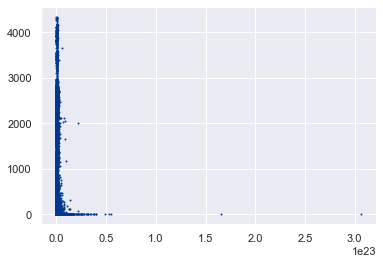

In [387]:
traces_value1_ = traces_value1.merge(market_data, on = 'date', how = 'left')
traces_value1_.close.fillna(3, inplace=True)

plt.scatter(traces_value1_.std_call.replace(0, np.mean(traces_value1_.std_call)), traces_value1_.close.replace(0, np.mean(traces_value1_.close)), color = pal[0], s = .9) #[int(3e4):] #.replace(0, 3)
# plt.xlim(xmin = 0, xmax = 2e21)
# plt.yscale('log')
# plt.xscale('log')

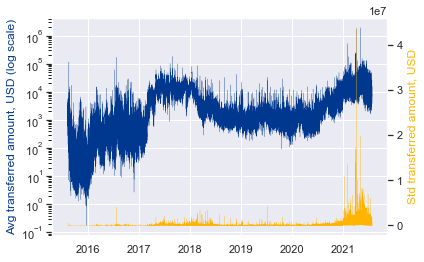

In [212]:
fig, ax1 = plt.subplots()

ax1.plot(traces_value1.date, traces_value1.avg_call, color = pal[0], linewidth = .2)
ax1.set_ylabel('Avg transferred amount, USD (log scale)', color = pal[0])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(traces_value1.date, traces_value1.std_call, color = pal[1], linewidth = .2)
ax2.set_ylabel('Std transferred amount, USD', color = pal[1])
ax2.grid(False)

## New addresses

In [389]:
new_addresses.columns

Index(['date', 'new_addresses', 'new_erc20', 'new_erc721',
       'new_other_contract'],
      dtype='object')

In [ ]:
traces_value1_ = traces_value1.merge(market_data, on = 'date', how = 'left')
traces_value1_.close.fillna(3, inplace=True)

plt.scatter(traces_value1_.std_call.replace(0, np.mean(traces_value1_.std_call)), traces_value1_.close.replace(0, np.mean(traces_value1_.close)), color = pal[0], s = .9) #[int(3e4):] #.replace(0, 3)
# plt.xlim(xmin = 0, xmax = 2e21)
# plt.yscale('log')
# plt.xscale('log')

In [125]:
# plt.plot(new_addresses.date, new_addresses.new_addresses, color = pal[0], linewidth = .2)

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(new_addresses.date, new_addresses.new_addresses, color = pal[0], linewidth = .2)
ax1.set_ylabel('Avg transferred amount, USD (log scale)', color = pal[0])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(new_addresses.date, new_addresses.new_addresses, color = pal[1], linewidth = .2)
ax2.set_ylabel('Std transferred amount, USD', color = pal[1])
ax2.grid(False)

## Addresses count, Gini coefficient and USD profit/loss quantiles

In [179]:
%%bigquery features --project fiery-rarity-322109

select date, address_count, gini, avg_balance_usd, stddev_balance_usd
from `fiery-rarity-322109.ethereum.features`
order by date

Downloading: 100%|██████████| 52609/52609 [00:03<00:00, 14189.46rows/s]


Many of the crypto-assets are stored in exchanges and don’t correspond to individual holders. This biases the Gini coefficient toward accumulation.
Gini is known to be sensitive to including small balances in the analysis and is usually done on large addresses only. Removing small balances, as we did here, biases the Gini coefficient toward distribution.
In our analysis all addresses are treated as individual holders. In reality, multiple addresses can belong to the same individual. This can bias the Gini either toward accumulation or distribution.

In [126]:
%%bigquery gini --project fiery-rarity-322109

with 
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `fiery-rarity-322109.ethereum.traces_new`
    where to_address is not null
    union all
    -- credits
    select from_address as address, -value as value, block_timestamp
    from `fiery-rarity-322109.ethereum.traces_new`
    where from_address is not null
    union all
    -- transaction fees debits
    select miner as address
    , sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value
    , block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions` t1
    left join `fiery-rarity-322109.ethereum.eth_usd_min` t2 on DATETIME_TRUNC(t1.block_timestamp, MINUTE) = TIMESTAMP_SECONDS(t2.time)
    join `bigquery-public-data.crypto_ethereum.blocks` as blocks on blocks.number = t1.block_number
    where date(t1.block_timestamp) <= '2021-07-30'
    group by blocks.miner, block_timestamp
    union all
    -- transaction fees credits
    select from_address as address
    , -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value
    , block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions` t1
    left join `fiery-rarity-322109.ethereum.eth_usd_min` t2 on DATETIME_TRUNC(t1.block_timestamp, MINUTE) = TIMESTAMP_SECONDS(t2.time)
    where date(block_timestamp) <= '2021-07-30'
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, '2021-07-30') over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array('2015-07-30', '2021-07-30')) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc

Downloading: 100%|██████████| 2192/2192 [00:03<00:00, 679.76rows/s]


In [137]:
import datetime

gini = gini[gini['date'] >= datetime.date(2017,1,1)].copy()

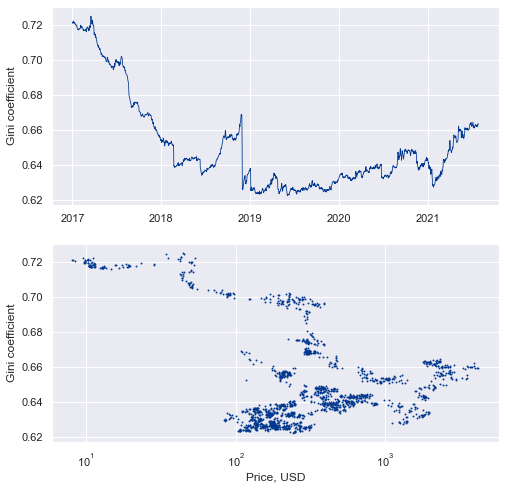

In [145]:
fig, ax1 = plt.subplots(2, 1, figsize=(8, 8))

ax1[0].plot(gini.date, gini.gini, color = pal[0], linewidth = .8)
ax1[0].set_ylabel('Gini coefficient')

gini_ = gini.merge(market_data1, on = 'date', how = 'left')

ax1[1].scatter(gini_.close, gini_.gini, color = pal[0], s = .8)
ax1[1].set_xlabel('Price, USD')
ax1[1].set_ylabel('Gini coefficient')
ax1[1].set_xscale('log')
# ax1[1].set_yscale('log')

# plt.tight_layout()
# plt.show()

plt.savefig("charts/gini.pdf")

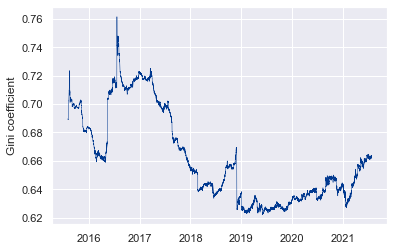

In [132]:
plt.plot(gini.date, gini.gini, color = pal[0], linewidth = .5) #, marker = '.', s = .2
plt.ylabel('Gini coefficient')
plt.show()

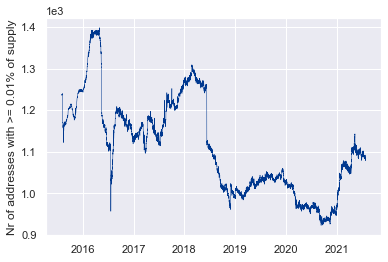

In [175]:
plt.plot(features.date[:-1], features.address_count[:-1], color = pal[0], linewidth = .5)
plt.ylabel('Addresses with >= 0.01% of supply')
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
plt.show()

In [ ]:
features_ = features.merge(market_data, on = 'date', how = 'left')
features_.close.fillna(3, inplace=True)

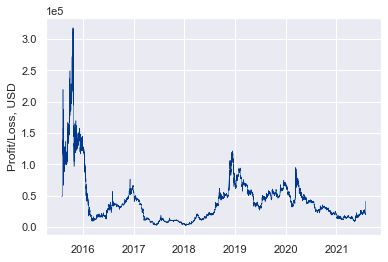

In [180]:
plt.plot(features_.date, features_.avg_balance_usd / features_.close, color = pal[0], linewidth = .5)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
plt.ylabel('Avg USD balance / price')
plt.show()

In [254]:
features_.columns

Index(['date', 'address_count', 'gini', 'avg_balance_usd',
       'stddev_balance_usd', 'close', 'high', 'low', 'volume'],
      dtype='object')

In [288]:
features_['return'] = np.log(features_.close / features_.close.shift(1))

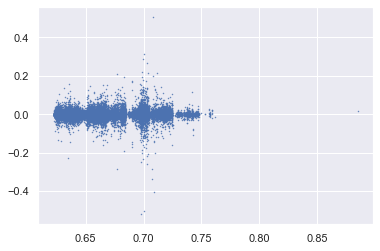

In [293]:
plt.scatter(features_.gini, features_['return'], s = .2)

In [ ]:
plt.scatter(features_.gini, features_.close, color = pal[0], s = .2) #[int(3e4):]
plt.xlim(xmax = .67)
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
plt.scatter(features_.address_count, features_.close, color = pal[0], s = .2) #[int(3e4):]
plt.xlim(xmin = 900, xmax = 1200)
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
plt.plot(features_.date, features_.stddev_balance_usd / features_.close, color = pal[0], linewidth = .5) # 
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
plt.ylabel('Profit/Loss, USD')
plt.show()

## Fees

In [117]:
%%bigquery fee1 --project fiery-rarity-322109

SELECT date(block_timestamp) as date #TIMESTAMP_TRUNC(block_timestamp, HOUR)
#, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric) / 1e18) as sum_fee_usd # * close
, avg(cast(receipt_gas_used as numeric) * cast(gas_price as numeric) / 1e18) as avg_fee_usd # / 1e18 * close
FROM `bigquery-public-data.crypto_ethereum.transactions` t1
left join `fiery-rarity-322109.ethereum.eth_usd_min` t2 on DATETIME_TRUNC(t1.block_timestamp, MINUTE) = TIMESTAMP_SECONDS(t2.time)
where date(block_timestamp) between '2017-01-01' and '2021-07-30'
group by date
order by date

Downloading: 100%|██████████| 1672/1672 [00:02<00:00, 758.23rows/s]


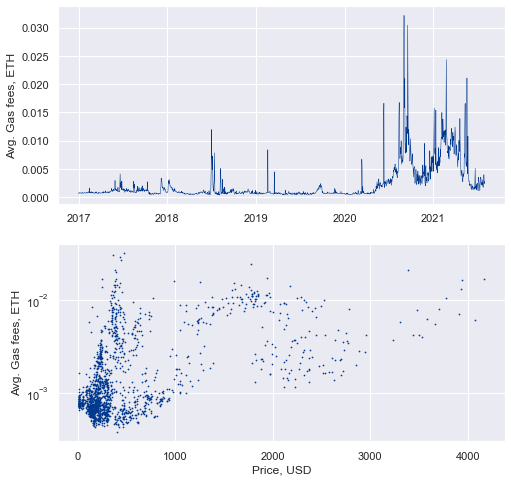

In [124]:
fig, ax1 = plt.subplots(2, 1, figsize=(8, 8))

ax1[0].plot(fee1.date, fee1.avg_fee_usd, color = pal[0], linewidth = .5)
ax1[0].set_ylabel('Avg. Gas fees, ETH')

# ax2 = ax1[0].twinx()
# ax2.plot(fee.date, fee.avg_fee_usd, color = pal[0], linewidth = .5)
# ax2.set_ylabel('Avg fees, USD (log scale)', color = pal[0])
# ax2.set_yscale('log')
# ax2.grid(False)

fee_ = fee1.merge(market_data1, on = 'date', how = 'left')

ax1[1].scatter(fee_.close, fee_.avg_fee_usd, color = pal[0], s = .5)
ax1[1].set_xlabel('Price, USD')
ax1[1].set_ylabel('Avg. Gas fees, ETH')
# ax1[1].set_xscale('log')
ax1[1].set_yscale('log')

# plt.tight_layout()
# plt.show()

plt.savefig("charts/avg_gas_fees.pdf")

## Degree distribution

In [83]:
# %%bigquery degree_distribution --project fiery-rarity-322109

# with outdegree as (
#     SELECT from_address address, count(*) outdegree FROM `fiery-rarity-322109.ethereum.traces_new`
#     WHERE DATE(block_timestamp) = "2021-07-30"
#     GROUP BY address
# )
# , indegree as (
#     SELECT to_address address, count(*) indegree FROM `fiery-rarity-322109.ethereum.traces_new`
#     WHERE DATE(block_timestamp) = "2021-07-30"
#     GROUP BY address
# )
# select ifnull(t1.address, t2.address) address, ifnull(indegree, 0) indegree, ifnull(outdegree, 0) outdegree
# from outdegree t1
# left outer join indegree t2 using (address)

Downloading: 100%|██████████| 276298/276298 [00:06<00:00, 39947.73rows/s]


In [35]:
%%bigquery indegree --project fiery-rarity-322109

select indegree, count(*) frequency
from (
    SELECT to_address address, count(*) indegree FROM `fiery-rarity-322109.ethereum.traces_new`
    WHERE DATE(block_timestamp) = "2021-07-30"
    GROUP BY address
)
group by indegree

Downloading: 100%|██████████| 316/316 [00:02<00:00, 115.00rows/s]


In [36]:
%%bigquery outdegree --project fiery-rarity-322109

select outdegree, count(*) frequency
from (
    SELECT from_address address, count(*) outdegree FROM `fiery-rarity-322109.ethereum.traces_new`
    WHERE DATE(block_timestamp) = "2021-07-30"
    GROUP BY address
)
group by outdegree

Downloading: 100%|██████████| 336/336 [00:02<00:00, 122.51rows/s]


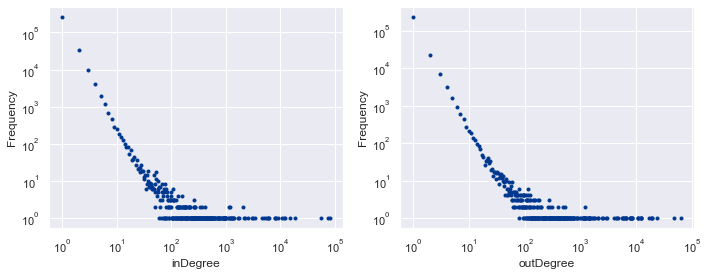

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4)) #

ax[0].scatter(indegree.indegree, indegree.frequency, color = pal[0], marker = '.')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('inDegree')
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].scatter(outdegree.outdegree, outdegree.frequency, color = pal[0], marker = '.')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('outDegree')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

plt.tight_layout()
# plt.show()

plt.savefig("charts/degrees_power_law.pdf")

In [77]:
%%bigquery degree1 --project fiery-rarity-322109

with outdegree_ as (
    SELECT date(block_timestamp) as date --TIMESTAMP_TRUNC(block_timestamp, HOUR)
    , from_address as address
    , count(*) as outdegree
    FROM `fiery-rarity-322109.ethereum.traces_new`
    where date(block_timestamp) between '2017-01-01' and '2021-07-30'
    GROUP BY date, address
)
, indegree_ as (
    SELECT date(block_timestamp) as date --TIMESTAMP_TRUNC(block_timestamp, HOUR)
    , to_address as address
    , count(*) as indegree
    FROM `fiery-rarity-322109.ethereum.traces_new`
    where date(block_timestamp) between '2017-01-01' and '2021-07-30'
    GROUP BY date, address
)
select ifnull(t1.date, t2.date) as date
, avg(ifnull(outdegree,0)) as avg_outdegree
, avg(ifnull(indegree,0)) as avg_indegree
, stddev(ifnull(outdegree,0)) as stddev_outdegree
, stddev(ifnull(indegree,0)) as stddev_indegree
from outdegree_ t1
full outer join indegree_ t2 using (address, date)
group by date
order by date

Downloading: 100%|██████████| 1672/1672 [00:03<00:00, 453.98rows/s]


In [53]:
%%bigquery market_data1 --project fiery-rarity-322109

SELECT  DATE(TIMESTAMP_SECONDS(time)) as date, close, high, low, volumeto as volume
FROM `fiery-rarity-322109.ethereum.eth_usd_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), DAY) and DATE(TIMESTAMP_SECONDS(time)) <= '2021-07-30'
order by date

Downloading: 100%|██████████| 2184/2184 [00:02<00:00, 767.71rows/s]


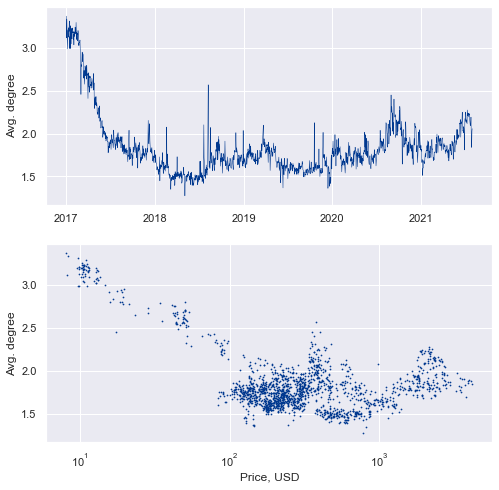

In [88]:
fig, ax1 = plt.subplots(2, 1, figsize=(8, 8))

ax1[0].plot(degree1.date, degree1.avg_indegree, color = pal[0], linewidth = .5)
ax1[0].set_ylabel('Avg. degree')
# ax1[0].set_yscale('log')

degree_ = degree1.merge(market_data1, on = 'date', how = 'left')

ax1[1].scatter(degree_.close, degree_.avg_indegree, color = pal[0], s = .5)
ax1[1].set_xlabel('Price, USD')
ax1[1].set_ylabel('Avg. degree')
# ax1[1].set_yscale('log')
ax1[1].set_xscale('log')

# plt.tight_layout()
# plt.show()

plt.savefig("charts/avg_degree.pdf")

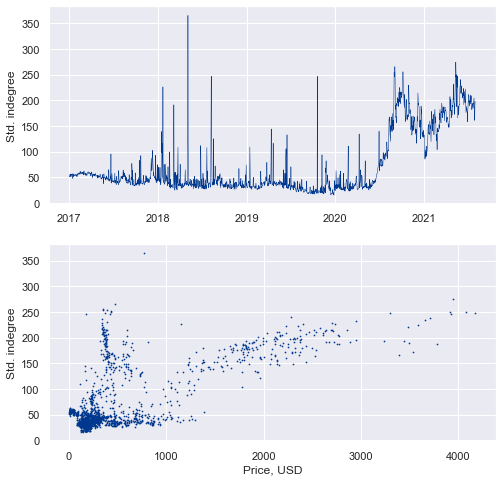

In [95]:
fig, ax1 = plt.subplots(2, 1, figsize=(8, 8))

ax1[0].plot(degree1.date, degree1.stddev_indegree, color = pal[0], linewidth = .5)
ax1[0].set_ylabel('Std. indegree')
# ax1[0].set_yscale('log')

degree_ = degree1.merge(market_data1, on = 'date', how = 'left')

ax1[1].scatter(degree_.close, degree_.stddev_indegree, color = pal[0], s = .5)
ax1[1].set_xlabel('Price, USD')
ax1[1].set_ylabel('Std. indegree')
# ax1[1].set_yscale('log')
# ax1[1].set_xscale('log')

# plt.tight_layout()
# plt.show()

plt.savefig("charts/std_indegree.pdf")

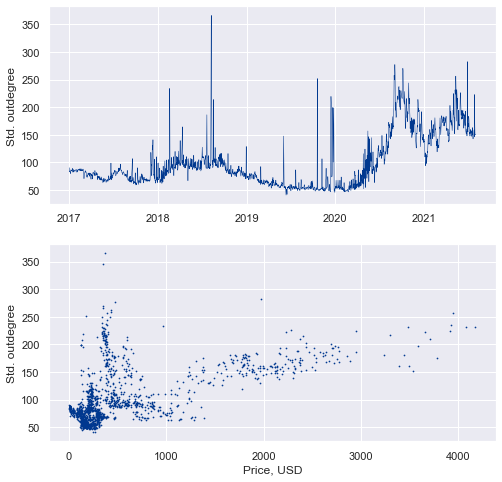

In [116]:
fig, ax1 = plt.subplots(2, 1, figsize=(8, 8))

ax1[0].plot(degree1.date, degree1.stddev_outdegree, color = pal[0], linewidth = .5)
ax1[0].set_ylabel('Std. outdegree')
# ax1[0].set_yscale('log')

degree_ = degree1.merge(market_data1, on = 'date', how = 'left')

ax1[1].scatter(degree_.close, degree_.stddev_outdegree, color = pal[0], s = .5)
ax1[1].set_xlabel('Price, USD')
ax1[1].set_ylabel('Std. outdegree')
# ax1[1].set_yscale('log')
# ax1[1].set_xscale('log')

# plt.tight_layout()
# plt.show()

plt.savefig("charts/std_outdegree.pdf")

## Addresses classification

In [5]:
%%bigquery address_clustering --project fiery-rarity-322109

--with address_rank as (
--    SELECT t1.*
--    , ROW_NUMBER() OVER(PARTITION BY t1.date_month ORDER BY t1.avg_balance DESC) AS rank
--    FROM `fiery-rarity-322109.ethereum.address_classification` t1
--)
--select * from address_rank where rank <= 300

select * from `fiery-rarity-322109.ethereum.address_classification` where rank <= 1000

Downloading: 100%|██████████| 72000/72000 [00:06<00:00, 10817.73rows/s]


In [11]:
print(address_clustering.shape, len(set(address_clustering.address)))
address_clustering.head(3)

# print('remove 0x0000000000000000000000000000000000000000!')

(72000, 20) 26564


,address,date_month,avg_count_trace_address_to,avg_count_trace_contract_to,avg_count_address_to,avg_count_contract_to,avg_sum_value_address_to,avg_sum_value_contract_to,avg_count_token_address_to,nr_days_to,avg_count_trace_address_from,avg_count_trace_contract_from,avg_count_address_from,avg_count_contract_from,avg_sum_value_address_from,avg_sum_value_contract_from,avg_count_token_address_from,nr_days_from,avg_balance,rank
0,0xb794f5ea0ba39494ce839613fffba74279579268,2016-06-01,1.000000,0.000000,1.000000,0.000000,1.113647e+06,0.000000,0.0,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0,7.582778e+24,1
1,0xd24400ae8bfebb18ca49be86258a3c749cf46853,2016-06-01,9.827586,3.068966,8.310345,0.482759,5.189872e+04,489987.700748,0.0,29,44.896552,0.103448,16.965517,0.034483,208957.199816,43.64632,0.0,29,4.152094e+23,2
2,0x91337a300e0361bddb2e377dd4e88ccb7796663d,2016-06-01,69.566667,2.033333,56.833333,1.366667,1.194132e+05,11700.497787,0.0,30,1347.566667,0.000000,741.233333,0.000000,248791.512677,0.00000,0.0,30,3.429605e+23,3


In [64]:
import datetime

# address_clustering = address_clustering[address_clustering['rank'] <= 300]

# df = address_clustering.loc[address_clustering.date_month == datetime.date(2021,6,1)
#                             , address_clustering.columns.isin(['date_month', 'avg_count_trace_contract_to', 'avg_sum_value_address_to', 'avg_balance'])]
df = address_clustering.loc[address_clustering.date_month == datetime.date(2018,1,1) , ~address_clustering.columns.isin(['date_month', 'address', 'rank'])] #, 'nr_days_to', 'nr_days_from'
df.head() #

,avg_count_trace_address_to,avg_count_trace_contract_to,avg_count_address_to,avg_count_contract_to,avg_sum_value_address_to,avg_sum_value_contract_to,avg_count_token_address_to,nr_days_to,avg_count_trace_address_from,avg_count_trace_contract_from,avg_count_address_from,avg_count_contract_from,avg_sum_value_address_from,avg_sum_value_contract_from,avg_count_token_address_from,nr_days_from,avg_balance
51000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,7.848802e+07,0.000000,6,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0,2.112500e+24
51001,1.789474,0.000000,1.000000,0.000000,3.865601e+07,0.000000e+00,0.000000,19,11.769231,0.000000,1.076923,0.000000,4.351990e+07,0.000000e+00,0.692308,13,1.182650e+24
51002,2.000000,0.000000,1.500000,0.000000,1.181813e+08,0.000000e+00,0.000000,2,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0,1.004859e+24
51003,53316.290323,1463.677419,10081.935484,247.290323,3.701762e+08,1.628978e+07,46.225806,31,2.225806,17879.967742,2.129032,5785.709677,3.544462e+03,1.326698e+08,38.580645,31,7.397658e+23
51004,1.000000,0.000000,1.000000,0.000000,1.929200e+07,0.000000e+00,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0,6.000001e+23


In [29]:
# pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


scaler = StandardScaler()
scaler.fit(df)
X_scale = scaler.transform(df)
df_scale = pd.DataFrame(X_scale, columns=df.columns)
df_scale.head()


tsne = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_scale_results = tsne.fit_transform(df_scale)
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])
plt.figure(figsize = (10,10))
plt.scatter(tsne_df_scale.iloc[:,0],tsne_df_scale.iloc[:,1],alpha=0.25, facecolor='lightslategray')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.show()

Text(0, 0.5, 'Inertia')

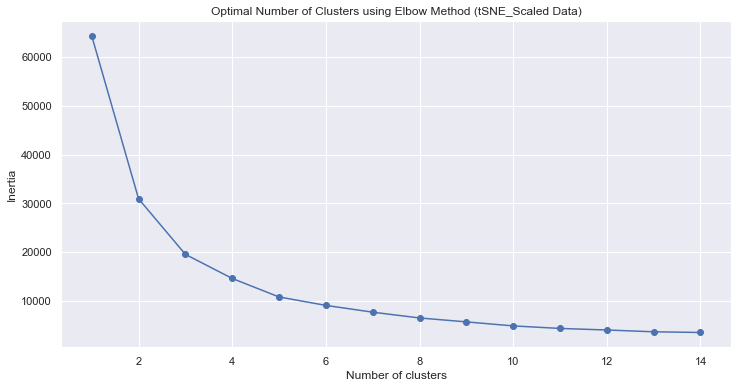

In [66]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(tsne_df_scale)
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': k_list, 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [67]:
kmeans_tsne_scale = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale.labels_, metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

KMeans tSNE Scaled Silhouette Score: 0.40974313020706177


In [ ]:
plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()

In [85]:
# clusters_tsne_scale
address_clustering.loc[address_clustering.date_month == datetime.date(2018,1,1), :].shape

(1000, 20)

In [88]:
address_clustering['tsne_clusters'] = clusters_tsne_scale['tsne_clusters']

In [86]:
clusters_tsne_scale.head()

,tsne1,tsne2,tsne3,tsne_clusters
0,4.742746,1.796353,-1.977678,0
1,4.454351,2.369938,-2.613143,0
2,4.370441,2.424561,-2.612018,0
3,10.222472,-4.517241,-4.490162,2
4,3.874020,2.692680,-2.454844,0


In [1]:
Scene = dict(xaxis = dict(title  = 'tsne1'),yaxis = dict(title  = 'tsne2'),zaxis = dict(title  = 'tsne3'))
labels = labels_tsne_scale
trace = go.Scatter3d(x=clusters_tsne_scale.iloc[:,0], y=clusters_tsne_scale.iloc[:,1], z=clusters_tsne_scale.iloc[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 5, line = dict(color = 'yellow',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [2]:
plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()

In [3]:
Scene = dict(xaxis = dict(title  = 'tsne1'),yaxis = dict(title  = 'tsne2'),zaxis = dict(title  = 'tsne3'))
labels = labels_tsne_scale
trace = go.Scatter3d(x=clusters_tsne_scale.iloc[:,0], y=clusters_tsne_scale.iloc[:,1], z=clusters_tsne_scale.iloc[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'yellow',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [72]:
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# power_transform = PowerTransformer(standardize=False)
scale = StandardScaler()
pca =PCA(n_components=df.shape[1])
# cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([#('log', power_transform ),
                 ('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(df)

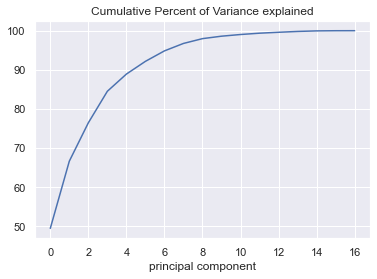

In [73]:
plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

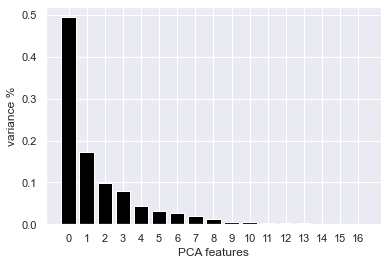

In [74]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)
# Create a PCA instance: pca
pca = PCA(n_components=df.shape[1])
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

(-4.35103857812494, 2.0)

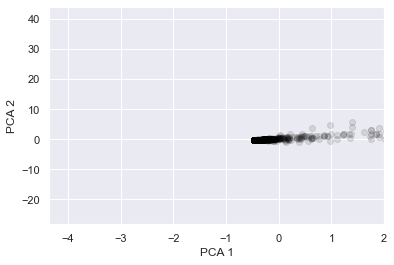

In [75]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.xlim(xmax = 2)

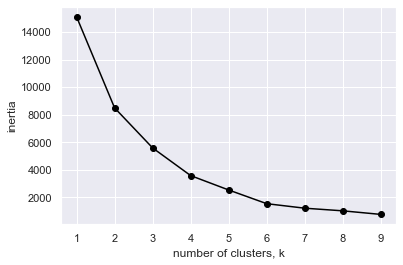

In [76]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:5])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [77]:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=6)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:5])

KMeans(n_clusters=6)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = PCA_components.iloc[:,:5].to_numpy()

range_n_clusters = [5,6,7]# [x for x in range(9)[3:]]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
# from sklearn.datasets import load_iris
import typing
from sklearn.preprocessing import StandardScaler #, RobustScaler

class SklearnWrapper:
    def __init__(self, transformation: typing.Callable):
        self.transformation = transformation
        self._group_transforms = []
        # Start with -1 and for each group up the pointer by one
        self._pointer = -1

    def _call_with_function(self, df: pd.DataFrame, function: str):
        # If pointer >= len we are making a new apply, reset _pointer
        if self._pointer >= len(self._group_transforms):
            self._pointer = -1
        self._pointer += 1
        return pd.DataFrame(
            getattr(self._group_transforms[self._pointer], function)(df.values),
            columns=df.columns,
            index=df.index,
        )

    def fit(self, df):
        self._group_transforms.append(self.transformation.fit(df.values))
        return self

    def transform(self, df):
        return self._call_with_function(df, "transform")

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

    def inverse_transform(self, df):
        return self._call_with_function(df, "inverse_transform")

# data = load_iris()
# df = pd.DataFrame(data["data"], columns=data["feature_names"])
# df["class"] = data["target"]

# Create scaler outside the class
scaler = SklearnWrapper(StandardScaler())

# Fit and transform data (holding state)
df_rescaled = df.groupby("date_month").apply(scaler.fit_transform)

# # Inverse the operation
# df_inverted = df_rescaled.groupby("class").apply(scaler.inverse_transform)

# # Apply transformation once again
# df_transformed = (
#     df_inverted.groupby("class")
#     .apply(scaler.transform)
#     .drop("class", axis="columns")
# )

In [ ]:
df_rescaled.head(3)

,avg_count_trace_address_to,avg_count_trace_contract_to,avg_count_address_to,avg_count_contract_to,avg_sum_value_address_to,avg_sum_value_contract_to,avg_count_token_address_to,nr_days_to,avg_count_trace_address_from,avg_count_trace_contract_from,avg_count_address_from,avg_count_contract_from,avg_sum_value_address_from,avg_sum_value_contract_from,avg_count_token_address_from,nr_days_from,avg_balance
62000,-0.196060,-0.210826,-0.207719,-0.230996,-0.242893,-0.237768,-0.147400,-0.780358,-0.122052,-0.108284,-0.162748,-0.104361,-0.126177,-0.156908,-0.142320,-0.655728,14.548843
62001,4.472717,5.077697,3.048896,3.629732,15.750198,2.373635,7.467687,1.755733,15.017201,-0.107168,8.305513,-0.102541,17.059648,-0.156906,13.909215,2.067645,4.530837
62002,0.170257,0.317750,0.498923,0.838093,0.757130,0.040743,-0.147400,1.755733,0.168516,-0.108284,0.806766,-0.104361,0.457064,-0.156908,-0.142320,2.067645,3.726692


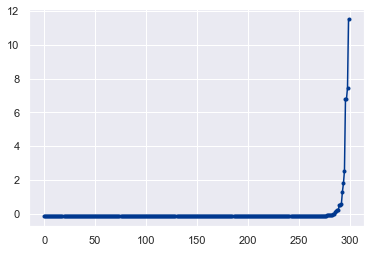

In [ ]:
plt.plot(df_rescaled.avg_count_token_address_to.sort_values().reset_index(drop=True), color = pal[0], marker = '.') #[250:]
# plt.yscale('log')

In [ ]:
# from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = df_rescaled.to_numpy()

range_n_clusters = [x for x in range(9)[3:]]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
# X = address_clustering.loc[address_clustering.date_month == datetime.date(2021,6,1), address_clustering.columns.isin(['avg_sum_value_address_to', 'avg_balance'])].to_numpy() #'avg_count_trace_contract_to', 
# X = StandardScaler().fit_transform(X)
import datetime

X = address_clustering.loc[address_clustering.date_month == datetime.date(2021,6,1), ~address_clustering.columns.isin(['date_month', 'address', 'nr_days_to', 'nr_days_from', 'rank'])].to_numpy()
X = StandardScaler().fit_transform(X)

In [4]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics

# # X = df_rescaled.to_numpy() #address_clustering.loc[address_clustering.date_month == datetime.date(2021,6,1), ~address_clustering.columns.isin(['address', 'nr_days_to', 'nr_days_from', 'date_month'])].to_numpy()

# db = DBSCAN().fit(X) #eps=0.3, min_samples=10
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# # print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# # print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# # print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# # print("Adjusted Rand Index: %0.3f"
# #       % metrics.adjusted_rand_score(labels_true, labels))
# # print("Adjusted Mutual Information: %0.3f"
# #       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

# # #############################################################################
# # Plot result
# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

In [ ]:
from collections import Counter
Counter(labels)

Counter({0: 1048, -1: 29})

## Return/price Prediction

## Miners

In [ ]:
%%bigquery test2 --project fiery-rarity-322109

select FORMAT_DATE('%m%Y', DATE(block_timestamp)) month
, count(distinct case when to_month_mined_blocks >= 20 then to_address else null end) count_miners
from `fiery-rarity-322109.ethereum.traces_new`
group by month
order by month

Downloading: 100%|██████████| 73/73 [00:02<00:00, 27.00rows/s]


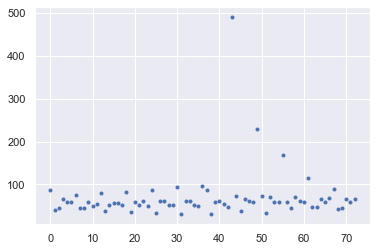

In [ ]:
plt.plot(test2.count_miners, 'b.')
# plt.ylim(ymax = 100, ymin = 0)

## Exchanges

In [ ]:
%%bigquery test3 --project fiery-rarity-322109

select date_month, count(*) count_address
from `fiery-rarity-322109.ethereum.address_classification`
group by date_month
# order by date_month

Downloading: 100%|██████████| 72/72 [00:02<00:00, 28.33rows/s]


(0.0, 7102311.5)

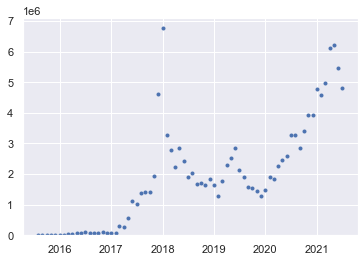

In [ ]:
from datetime import datetime

test3['date'] = [datetime.strptime(x, '%m%Y') for x in test3.date_month]
plt.plot(test3.date, test3.count_address, 'b.')
plt.ylim(ymin = 0)